# Import stuff

In [1]:
import sys
sys.path.append("..")
import grading
import download_utils

In [2]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [4]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import grading_utils
import keras_utils


/home/vin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


1.2.1
2.0.6


# Load dataset

In [10]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [11]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [12]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

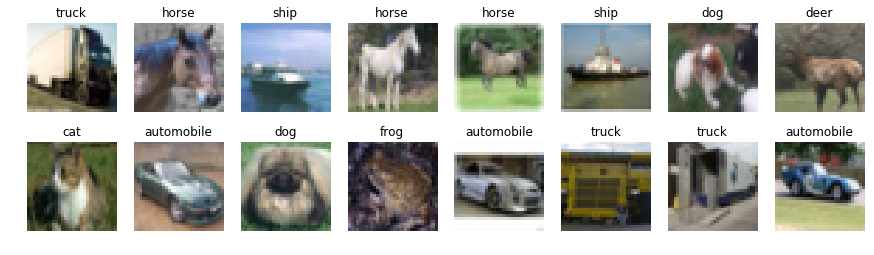

In [13]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Prepare data

In [41]:
# normalize inputs
from keras.utils import to_categorical
x_train2 = x_train/255 -0.5
x_test2 = x_test/255 -0.5

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = to_categorical(y_train,10)
y_test2 =  to_categorical(y_test,10)


In [42]:
y_train2[1,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

# Define CNN architecture

In [43]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [44]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    model.add(Conv2D(16, (3, 3), input_shape=(32,32,3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES))
    model.add(Activation("softmax"))
    
    return model

In [45]:
# describe model
#K.clear_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        9248      
__________

# Train model

In [86]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [87]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 7
# model = load_model(model_filename.format(last_finished_epoch))

In [88]:
# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               keras_utils.TqdmProgressCallback(),
               keras_utils.ModelSaveCallback(model_filename)],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=1,
    initial_epoch=last_finished_epoch or 0
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
Learning rate: 0.005
Epoch 1/10


50000/50000 [==============================] - 124s 2ms/step - loss: 1.3457 - acc: 0.5189 - val_loss: 1.0443 - val_acc: 0.6293

Model saved in cifar.000.hdf5
Epoch 2/10
Learning rate: 0.0045
Epoch 2/10


50000/50000 [==============================] - 131s 3ms/step - loss: 0.9459 - acc: 0.6681 - val_loss: 0.8596 - val_acc: 0.6998

Model saved in cifar.001.hdf5
Epoch 3/10
Learning rate: 0.00405
Epoch 3/10


50000/50000 [==============================] - 106s 2ms/step - loss: 0.8146 - acc: 0.7162 - val_loss: 0.7470 - val_acc: 0.7417

Model saved in cifar.002.hdf5
Epoch 4/10
Learning rate: 0.003645
Epoch 4/10


50000/50000 [==============================] - 114s 2ms/step - loss: 0.7365 - acc: 0.7437 - val_loss: 0.6967 - val_acc: 0.7612

Model saved in cifar.003.hdf5
Epoch 5/10
Learning rate: 0.0032805
Epoch 5/10


50000/50000 [==============================] - 148s 3ms/step - loss: 0.6704 - acc: 0.7654 - val_loss: 0.6844 - val_acc: 0.7679

Model saved in cifar.004.hdf5
Epoch 6/10
Learning rate: 0.00295245
Epoch 6/10


50000/50000 [==============================] - 113s 2ms/step - loss: 0.6225 - acc: 0.7813 - val_loss: 0.6664 - val_acc: 0.7729

Model saved in cifar.005.hdf5
Epoch 7/10
Learning rate: 0.002657205
Epoch 7/10


50000/50000 [==============================] - 138s 3ms/step - loss: 0.5754 - acc: 0.7980 - val_loss: 0.6347 - val_acc: 0.7890

Model saved in cifar.006.hdf5
Epoch 8/10
Learning rate: 0.0023914846
Epoch 8/10


50000/50000 [==============================] - 132s 3ms/step - loss: 0.5435 - acc: 0.8098 - val_loss: 0.6348 - val_acc: 0.7915

Model saved in cifar.007.hdf5
Epoch 9/10
Learning rate: 0.002152336
Epoch 9/10


50000/50000 [==============================] - 137s 3ms/step - loss: 0.5112 - acc: 0.8192 - val_loss: 0.6299 - val_acc: 0.7938

Model saved in cifar.008.hdf5
Epoch 10/10
Learning rate: 0.0019371024
Epoch 10/10


50000/50000 [==============================] - 117s 2ms/step - loss: 0.4897 - acc: 0.8286 - val_loss: 0.6134 - val_acc: 0.7978

Model saved in cifar.009.hdf5


In [89]:
# save weights to file
model.save_weights("weights.h5")

In [90]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

# Evaluate model

In [32]:
# make test predictions
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

 9984/10000 [============================>.] - ETA: 0s

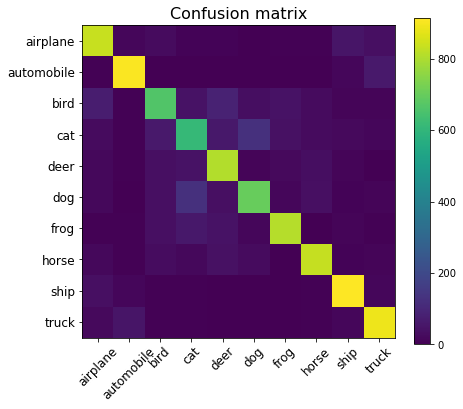

Test accuracy: 0.7978


In [33]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

/home/vin/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


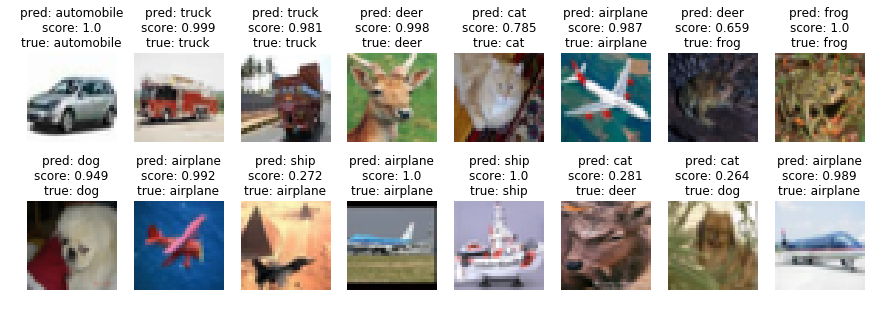

In [96]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Visualize maximum stimuli

In [20]:
K.clear_session()  # clear default graph
K.set_learning_phase(0)  # disable dropout
model = make_model()
model.load_weights("weights.h5")  # that were saved after model.fit

In [21]:
# all weights we have
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
__________

In [22]:
def find_maximum_stimuli(layer_name, is_conv, filter_index, model, iterations=20, step=1., verbose=True):
    
    def image_values_to_rgb(x):
        # normalize x: center on 0 (np.mean(x_train2)), ensure std is 0.25 (np.std(x_train2))
        # so that it looks like a normalized image input for our network
        x = (x-np.mean(x_train2))/np.std(x_train2)

        # do reverse normalization to RGB values: x = (x_norm + 0.5) * 255
        x = (x+0.5)*255
    
        # clip values to [0, 255] and convert to bytes
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    # this is the placeholder for the input image
    input_img = model.input
    img_width, img_height = input_img.shape.as_list()[1:3]
    
    # find the layer output by name
    layer_output = list(filter(lambda x: x.name == layer_name, model.layers))[0].output

    # we build a loss function that maximizes the activation
    # of the filter_index filter of the layer considered
    if is_conv:
        # mean over feature map values for convolutional layer
        loss = K.mean(layer_output[:, :, :, filter_index])
    else:
        loss = K.mean(layer_output[:, filter_index])

    # we compute the gradient of the loss wrt input image
    grads = K.gradients(loss, input_img)[0]  # [0] because of the batch dimension!

    # normalization trick: we normalize the gradient
    grads = grads / (K.sqrt(K.sum(K.square(grads))) + 1e-10)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * (0.1 if is_conv else 0.001)

    # we run gradient ascent
    for i in range(iterations):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if verbose:
            print('Current loss value:', loss_value)

    # decode the resulting input image
    img = image_values_to_rgb(input_img_data[0])
    
    return img, loss_value

In [23]:
# sample maximum stimuli
def plot_filters_stimuli(layer_name, is_conv, model, iterations=20, step=1., verbose=False):
    cols = 8
    rows = 2
    filter_index = 0
    max_filter_index = list(filter(lambda x: x.name == layer_name, model.layers))[0].output.shape.as_list()[-1] - 1
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            if filter_index <= max_filter_index:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid('off')
                ax.axis('off')
                loss = -1e20
                while loss < 0 and filter_index <= max_filter_index:
                    stimuli, loss = find_maximum_stimuli(layer_name, is_conv, filter_index, model,
                                                         iterations, step, verbose=verbose)
                    filter_index += 1
                if loss > 0:
                    ax.imshow(stimuli)
                    ax.set_title("Filter #{}".format(filter_index))
    plt.show()

leaky_re_lu_1


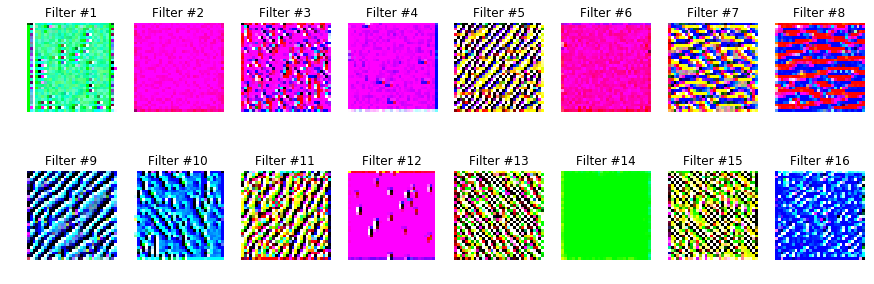

leaky_re_lu_2


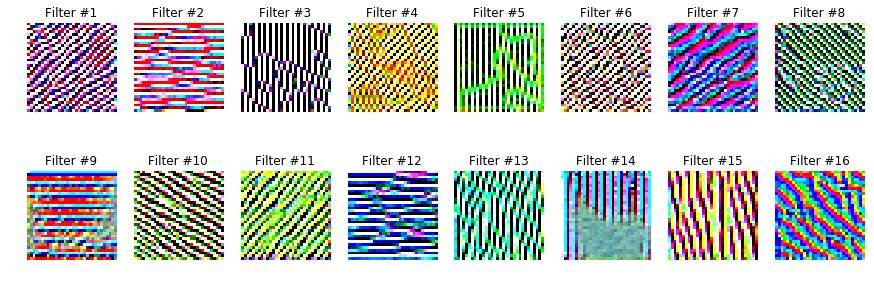

leaky_re_lu_3


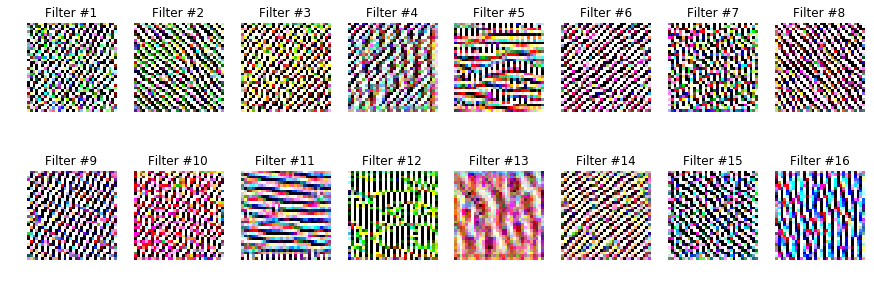

leaky_re_lu_4


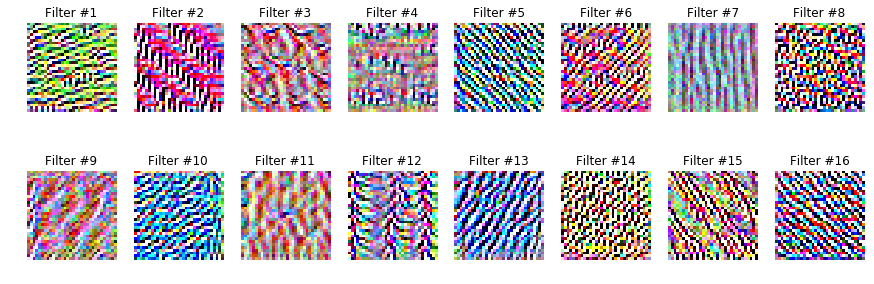

In [27]:
# maximum stimuli for convolutional neurons
conv_activation_layers = []
for layer in model.layers:
    if isinstance(layer, LeakyReLU):
        prev_layer = layer.inbound_nodes[0].inbound_layers[0]
        if isinstance(prev_layer, Conv2D):
            conv_activation_layers.append(layer)

for layer in conv_activation_layers:
    print(layer.name)
    plot_filters_stimuli(layer_name=layer.name, is_conv=True, model=model)

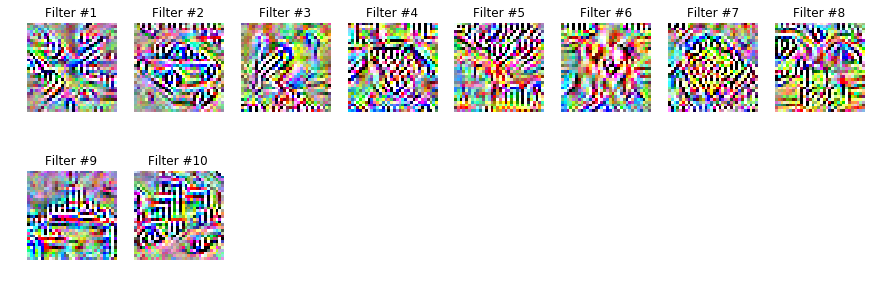

In [28]:
# maximum stimuli for last dense layer
last_dense_layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
plot_filters_stimuli(layer_name=last_dense_layer.name, is_conv=False, 
                     iterations=200, step=0.1, model=model)

In [29]:
def maximum_stimuli_test_for_grader():
    layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
    output_index = 7
    stimuli, loss = find_maximum_stimuli(
        layer_name=layer.name, 
        is_conv=False, 
        filter_index=output_index,
        model=model,
        verbose=False
    )
    return model.predict_proba(stimuli[np.newaxis, :])[0, output_index]